In [1]:
import numpy as np
import pandas as pd

import lightgbm

from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from GNN.utils.cm import plot_confusion_matrix
from GNN.utils.datautils import (
    get_data,
    pca_transform,
    balance_dataset,
    find_transition_regions
)

/cosma/local/Python/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cosma/local/Python/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
label = "dark_or_light"
sampling = "downsample"

# 1. Load combined features from SubFind & Sownak 

In [3]:
output_file = 'merged_dataframe.h5'                                          
data_path = '/cosma6/data/dp004/dc-cues1/tng_dataframes/'

train, test = get_data(data_path + output_file, label)
print(len(train.columns.values))
train.sample(n=3, random_state=1)

20


,M200_DMO,M200c,Rmax,R200c,Cnfw,Rhosnfw,Formation Time,Nmergers,MassPeak,vpeak,N_subhalos,VelDisp,Vmax,Spin,fsub_unbound,x_offset,x_dmo,y_dmo,z_dmo,labels
33967,3.222000e+11,3.222035e+11,0.025756,111.500549,9.541781,1.095388e+07,1.151545,1.0,5.354194e+11,158.870071,1.0,73.738907,132.469254,13.077200,0.007121,657.466485,265.680687,269.871812,199.033187,True
87515,1.594000e+11,1.594472e+11,0.015614,88.186943,16.635263,4.515792e+07,1.966384,1.0,2.638693e+11,116.536285,2.0,62.604664,114.830658,5.033566,0.008136,2196.179003,144.617547,260.009687,162.087938,True
14264,4.474000e+11,4.473788e+11,0.058838,124.389297,4.836464,2.172080e+06,1.044931,2.0,7.858822e+11,138.228745,9.0,74.484482,128.212570,10.046845,0.170153,1174.137065,42.755012,50.261793,204.619156,True


In [4]:
## Balance training set in the transition region                             
center_transition, end_transition = find_transition_regions(train)

train = balance_dataset(                                                     
    train, center_transition, end_transition, sampling
)

/cosma/home/dp004/dc-beck3/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [5]:
train_features = train.drop(columns="labels")                                
train_labels = train["labels"]

test_features = test.drop(columns="labels")                                
test_labels = test["labels"]

feature_names = train_features.columns.values

In [6]:
## Standarize features                                                       
scaler = StandardScaler()
scaler.fit(train_features.values)
train_features_std = scaler.transform(train_features.values)
test_features_std = scaler.transform(test_features.values)

#train_labels = train_labels.values
#test_labels = test_labels.values

# !!!
# notice that features and labels are np.ndarrays now
# !!!

In [7]:
# np.ndarray back to pd.datafram
train_features = pd.DataFrame(
    data=train_features_std,
    index=np.arange(train_features_std.shape[0]),
    columns=feature_names,
)

test_features = pd.DataFrame(
    data=test_features_std,
    index=np.arange(test_features_std.shape[0]),
    columns=feature_names,
)

In [8]:
list(feature_names)

['M200_DMO',
 'M200c',
 'Rmax',
 'R200c',
 'Cnfw',
 'Rhosnfw',
 'Formation Time',
 'Nmergers',
 'MassPeak',
 'vpeak',
 'N_subhalos',
 'VelDisp',
 'Vmax',
 'Spin',
 'fsub_unbound',
 'x_offset',
 'x_dmo',
 'y_dmo',
 'z_dmo']

In [9]:
## PCA decomposition
"""
train_features_pca_cvs, test_features_pca_cvs, n_compontent_cvs = pca_transform(
    train_features_std, test_features_std, 'cross_val',
)
"""

"\ntrain_features_pca_cvs, test_features_pca_cvs, n_compontent_cvs = pca_transform(\n    train_features_std, test_features_std, 'cross_val',\n)\n"

## 2. LightGBM

In [10]:
# Create the LightGBM training data containers

x, x_test, y, y_test = train_test_split(
    train_features.values, train_labels.values,
    test_size=0.2,
    random_state=42,
    stratify=train_labels.values
)

lgb_train = lightgbm.Dataset(
    x,
    label=y,
    #categorical_feature=list(feature_names)
)
lgb_eval = lightgbm.Dataset(
    x_test,
    label=y_test
)

In [11]:
# set training parameters
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'false',
    'boosting': 'gbdt',
    'num_leaves': 10,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'learning_rate': 0.05,
    'verbose': 0
}

In [12]:
model = lightgbm.train(
    parameters,
    lgb_train,
    valid_sets=lgb_eval,
    num_boost_round=50,
    early_stopping_rounds=5,
)

[1]	valid_0's auc: 0.858937
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.861391
[3]	valid_0's auc: 0.862365
[4]	valid_0's auc: 0.864192
[5]	valid_0's auc: 0.868937
[6]	valid_0's auc: 0.868905
[7]	valid_0's auc: 0.871961
[8]	valid_0's auc: 0.873662
[9]	valid_0's auc: 0.874702
[10]	valid_0's auc: 0.875699
[11]	valid_0's auc: 0.87508
[12]	valid_0's auc: 0.87625
[13]	valid_0's auc: 0.877686
[14]	valid_0's auc: 0.878558
[15]	valid_0's auc: 0.878864
[16]	valid_0's auc: 0.879586
[17]	valid_0's auc: 0.879874
[18]	valid_0's auc: 0.880367
[19]	valid_0's auc: 0.881315
[20]	valid_0's auc: 0.881797
[21]	valid_0's auc: 0.882949
[22]	valid_0's auc: 0.883497
[23]	valid_0's auc: 0.884017
[24]	valid_0's auc: 0.884652
[25]	valid_0's auc: 0.885243
[26]	valid_0's auc: 0.885849
[27]	valid_0's auc: 0.886225
[28]	valid_0's auc: 0.886478
[29]	valid_0's auc: 0.88661
[30]	valid_0's auc: 0.887197
[31]	valid_0's auc: 0.887755
[32]	valid_0's auc: 0.887984
[33]	valid_0's auc: 0.8

In [41]:
test_pred = model.predict(test_features)
test_pred = test_pred > 0.5
np.unique(test_pred)

array([False,  True])

Normalized confusion matrix


(array([[0.79190628, 0.20809372],
        [0.15746206, 0.84253794]]),
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff7c83251d0>)

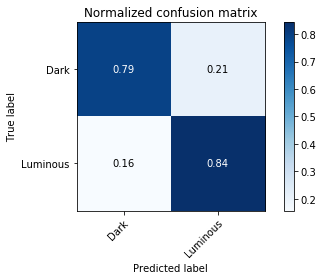

In [42]:
plot_confusion_matrix(test_labels, test_pred, 
    classes = ['Dark', 'Luminous'], normalize = True)